# **Query Analyzer Strategy Benchmark**

## **Strategies Tested**

1. **Keyword** - Fast rule-based extraction
2. **Translation** - Vietnamese to English translation for CLIP
3. **Semantic** - PhoBERT-based semantic matching (4 models)

## **Metrics Tracked**
- Initialization time
- Inference time (per query)
- Memory usage
- Accuracy/confidence scores

## **Setup**

In [45]:
import sys
import time
import psutil
import gc
import warnings
from typing import List, Dict, Any
from dataclasses import dataclass, field

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, '..')

from src.perception.query_analyzer import (
    QueryAnalyzer,
    QueryAnalysisResult,
    QuestionIntent,
    get_available_strategies,
)

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
print(f"Available strategies: {get_available_strategies()}")

Available strategies: ['keyword', 'translation', 'semantic']


## **Test Questions**

In [46]:
TEST_QUESTIONS = [
    # Speed/Value questions
    "Biển báo tốc độ tối đa là bao nhiêu?",
    "Giới hạn tốc độ trên đường cao tốc là mấy km/h?",
    
    # Existence questions
    "Trong video có đèn đỏ không?",
    "Có biển cấm dừng đỗ không?",
    
    # Permission questions
    "Có được phép rẽ trái không?",
    "Xe mô tô có được phép đi ở làn này không?",
    
    # Direction questions
    "Xe phải đi hướng nào?",
    "Có được quay đầu ở đây không?",
    
    # Temporal questions
    "Biển cấm nào xuất hiện đầu tiên?",
    "Đèn giao thông hiện tại là màu gì?",
    
    # Counting questions
    "Có mấy loại biển báo trong video?",
    "Có bao nhiêu làn đường?",
    
    # Without exact keywords (tests semantic matching)
    "Xe co the vuot khong?",
    "Duong co cho phep di tiep khong?",
]

print(f"Total test questions: {len(TEST_QUESTIONS)}")
for i, q in enumerate(TEST_QUESTIONS, 1):
    print(f"  {i}. {q}")

Total test questions: 14
  1. Biển báo tốc độ tối đa là bao nhiêu?
  2. Giới hạn tốc độ trên đường cao tốc là mấy km/h?
  3. Trong video có đèn đỏ không?
  4. Có biển cấm dừng đỗ không?
  5. Có được phép rẽ trái không?
  6. Xe mô tô có được phép đi ở làn này không?
  7. Xe phải đi hướng nào?
  8. Có được quay đầu ở đây không?
  9. Biển cấm nào xuất hiện đầu tiên?
  10. Đèn giao thông hiện tại là màu gì?
  11. Có mấy loại biển báo trong video?
  12. Có bao nhiêu làn đường?
  13. Xe co the vuot khong?
  14. Duong co cho phep di tiep khong?


## **Benchmark Utilities**

In [47]:
@dataclass
class BenchmarkResult:
    """Results from benchmarking a strategy."""
    strategy_name: str
    model_name: str = ""
    init_time_ms: float = 0.0
    avg_inference_ms: float = 0.0
    min_inference_ms: float = 0.0
    max_inference_ms: float = 0.0
    total_inference_ms: float = 0.0
    memory_mb: float = 0.0
    avg_confidence: float = 0.0
    avg_objects_found: float = 0.0
    results: List[QueryAnalysisResult] = field(default_factory=list)
    inference_times: List[float] = field(default_factory=list)


def get_memory_usage_mb() -> float:
    """Get current memory usage in MB."""
    process = psutil.Process()
    return process.memory_info().rss / (1024 * 1024)


def benchmark_strategy(
    strategy: str,
    questions: List[str],
    model_name: str = "",
    num_warmup: int = 2,
    num_runs: int = 3,
) -> BenchmarkResult:
    """Benchmark a query analyzer strategy.
    
    Args:
        strategy: Strategy name ("keyword", "translation", "semantic")
        questions: List of questions to test
        model_name: Model name for semantic strategy
        num_warmup: Number of warmup runs
        num_runs: Number of timed runs per question
        
    Returns:
        BenchmarkResult with timing and metrics
    """
    gc.collect()
    memory_before = get_memory_usage_mb()
    
    # Initialize analyzer
    init_start = time.perf_counter()
    if strategy == "semantic" and model_name:
        analyzer = QueryAnalyzer(strategy=strategy, semantic_model=model_name)
    else:
        analyzer = QueryAnalyzer(strategy=strategy)
    init_time = (time.perf_counter() - init_start) * 1000
    
    memory_after = get_memory_usage_mb()
    memory_used = memory_after - memory_before
    
    # Warmup runs
    for _ in range(num_warmup):
        for q in questions[:3]:
            _ = analyzer.analyze(q)
    
    # Timed runs
    all_results = []
    all_times = []
    
    for q in questions:
        q_times = []
        result = None
        
        for _ in range(num_runs):
            start = time.perf_counter()
            result = analyzer.analyze(q)
            elapsed = (time.perf_counter() - start) * 1000
            q_times.append(elapsed)
        
        all_results.append(result)
        all_times.append(sum(q_times) / len(q_times))  # Average time for this question
    
    # Calculate metrics
    avg_confidence = sum(r.confidence for r in all_results) / len(all_results)
    avg_objects = sum(len(r.target_objects) for r in all_results) / len(all_results)
    
    return BenchmarkResult(
        strategy_name=strategy,
        model_name=model_name or "default",
        init_time_ms=init_time,
        avg_inference_ms=sum(all_times) / len(all_times),
        min_inference_ms=min(all_times),
        max_inference_ms=max(all_times),
        total_inference_ms=sum(all_times),
        memory_mb=max(0, memory_used),
        avg_confidence=avg_confidence,
        avg_objects_found=avg_objects,
        results=all_results,
        inference_times=all_times,
    )


def display_benchmark_results(results: List[BenchmarkResult]):
    """Display benchmark results as a formatted table."""
    data = []
    for r in results:
        data.append({
            "Strategy": r.strategy_name,
            "Model": r.model_name,
            "Init Time (ms)": f"{r.init_time_ms:.1f}",
            "Avg Inference (ms)": f"{r.avg_inference_ms:.2f}",
            "Min/Max (ms)": f"{r.min_inference_ms:.2f}/{r.max_inference_ms:.2f}",
            "Memory (MB)": f"{r.memory_mb:.1f}",
            "Avg Confidence": f"{r.avg_confidence:.2f}",
            "Avg Objects": f"{r.avg_objects_found:.1f}",
        })
    
    df = pd.DataFrame(data)
    return df

## **1. Keyword Strategy Benchmark**

In [48]:
print("Benchmarking KEYWORD strategy")

keyword_result = benchmark_strategy("keyword", TEST_QUESTIONS)

print(f"\nKeyword Strategy results")
print(f"  Init Time: {keyword_result.init_time_ms:.2f} ms")
print(f"  Avg Inference: {keyword_result.avg_inference_ms:.4f} ms")
print(f"  Memory: {keyword_result.memory_mb:.1f} MB")
print(f"  Avg Confidence: {keyword_result.avg_confidence:.2f}")
print(f"  Avg Objects Found: {keyword_result.avg_objects_found:.1f}")

Benchmarking KEYWORD strategy

Keyword Strategy results
  Init Time: 0.01 ms
  Avg Inference: 0.0151 ms
  Memory: 0.0 MB
  Avg Confidence: 0.46
  Avg Objects Found: 1.6


In [49]:
# Show sample results from keyword strategy
print("Sample Keyword results")

for i, (q, r) in enumerate(zip(TEST_QUESTIONS[:5], keyword_result.results[:5])):
    print(f"\nQ{i+1}: {q}")
    print(f"    Intent: {r.question_intent.value}")
    print(f"    Objects: {r.target_objects[:3]}")
    print(f"    YOLO Classes: {r.yolo_classes}")
    print(f"    Keywords: {r.keywords_found}")
    print(f"    Confidence: {r.confidence:.2f}")

Sample Keyword results

Q1: Biển báo tốc độ tối đa là bao nhiêu?
    Intent: value
    Objects: ['max_speed_sign', 'speed_limit_sign', 'traffic_sign']
    YOLO Classes: ['traffic sign']
    Keywords: ['tốc độ tối đa', 'biển báo']
    Confidence: 0.70

Q2: Giới hạn tốc độ trên đường cao tốc là mấy km/h?
    Intent: value
    Objects: ['speed_limit_sign', 'highway', 'expressway']
    YOLO Classes: ['road', 'traffic sign']
    Keywords: ['giới hạn tốc độ', 'đường cao tốc', 'cao tốc']
    Confidence: 1.00

Q3: Trong video có đèn đỏ không?
    Intent: existence
    Objects: ['red_light', 'traffic_light_red']
    YOLO Classes: ['traffic light']
    Keywords: ['đèn đỏ']
    Confidence: 0.40

Q4: Có biển cấm dừng đỗ không?
    Intent: existence
    Objects: ['no_parking_sign', 'prohibitory_sign', 'no_stopping_sign']
    YOLO Classes: ['traffic sign']
    Keywords: ['cấm dừng đỗ', 'biển cấm', 'cấm dừng']
    Confidence: 1.00

Q5: Có được phép rẽ trái không?
    Intent: permission
    Objects: [

## **2. Translation Strategy Benchmark**

In [50]:
print("Benchmarking TRANSLATION strategy")

translation_result = benchmark_strategy("translation", TEST_QUESTIONS)

print(f"\nTranslation Strategy results")
print(f"  Init Time: {translation_result.init_time_ms:.2f} ms")
print(f"  Avg Inference: {translation_result.avg_inference_ms:.2f} ms")
print(f"  Memory: {translation_result.memory_mb:.1f} MB")
print(f"  Avg Confidence: {translation_result.avg_confidence:.2f}")
print(f"  Avg Objects Found: {translation_result.avg_objects_found:.1f}")

Benchmarking TRANSLATION strategy

Translation Strategy results
  Init Time: 0.05 ms
  Avg Inference: 585.10 ms
  Memory: 0.0 MB
  Avg Confidence: 0.46
  Avg Objects Found: 1.6


In [51]:
# Show translation examples
print("Translation Examples:")

for i, (q, r) in enumerate(zip(TEST_QUESTIONS[:5], translation_result.results[:5])):
    print(f"\nQ{i+1}: {q}")
    print(f"    -> {r.translated_question}")
    print(f"    Intent: {r.question_intent.value}")

Translation Examples:

Q1: Biển báo tốc độ tối đa là bao nhiêu?
    -> What is the maximum speed sign?
    Intent: value

Q2: Giới hạn tốc độ trên đường cao tốc là mấy km/h?
    -> What is the speed limit on the highway?
    Intent: value

Q3: Trong video có đèn đỏ không?
    -> Is there a red light in the video?
    Intent: existence

Q4: Có biển cấm dừng đỗ không?
    -> Is there a sign prohibiting parking?
    Intent: existence

Q5: Có được phép rẽ trái không?
    -> Are left turns allowed?
    Intent: permission


# **3. Semantic Strategy Benchmark (4 Models)**

Testing all 4 supported models:
1. `vinai/phobert-base` - Raw PhoBERT (default)
2. `dangvantuan/vietnamese-embedding` - Native sentence-transformers
3. `keepitreal/vietnamese-sbert` - Vietnamese SBERT
4. `AITeamVN/Vietnamese_Embedding` - Fine-tuned from BGE-M3

In [52]:
SEMANTIC_MODELS = [
    "vinai/phobert-base",
    "dangvantuan/vietnamese-embedding",
    "keepitreal/vietnamese-sbert",
    "AITeamVN/Vietnamese_Embedding",
]

semantic_results = []

for model_name in SEMANTIC_MODELS:
    print(f"Benchmarking SEMANTIC strategy with: {model_name}")

    try:
        result = benchmark_strategy("semantic", TEST_QUESTIONS, model_name=model_name)
        semantic_results.append(result)
        
        print(f"\nResults for {model_name}:")
        print(f"  Init Time: {result.init_time_ms:.2f} ms")
        print(f"  Avg Inference: {result.avg_inference_ms:.2f} ms")
        print(f"  Memory: {result.memory_mb:.1f} MB")
        print(f"  Avg Confidence: {result.avg_confidence:.2f}")
        print(f"  Avg Objects Found: {result.avg_objects_found:.1f}")
        
        # Clear memory
        gc.collect()
        
    except Exception as e:
        print(f"Failed: {e}")
        semantic_results.append(BenchmarkResult(
            strategy_name="semantic",
            model_name=model_name,
            init_time_ms=-1,
        ))

Benchmarking SEMANTIC strategy with: vinai/phobert-base

Results for vinai/phobert-base:
  Init Time: 3211.90 ms
  Avg Inference: 10.98 ms
  Memory: 555.4 MB
  Avg Confidence: 0.58
  Avg Objects Found: 7.1
Benchmarking SEMANTIC strategy with: dangvantuan/vietnamese-embedding

Results for dangvantuan/vietnamese-embedding:
  Init Time: 3856.96 ms
  Avg Inference: 12.55 ms
  Memory: 321.6 MB
  Avg Confidence: 0.57
  Avg Objects Found: 2.1
Benchmarking SEMANTIC strategy with: keepitreal/vietnamese-sbert

Results for keepitreal/vietnamese-sbert:
  Init Time: 3889.69 ms
  Avg Inference: 11.66 ms
  Memory: 322.6 MB
  Avg Confidence: 0.60
  Avg Objects Found: 3.4
Benchmarking SEMANTIC strategy with: AITeamVN/Vietnamese_Embedding

Results for AITeamVN/Vietnamese_Embedding:
  Init Time: 5404.48 ms
  Avg Inference: 41.84 ms
  Memory: 947.1 MB
  Avg Confidence: 0.64
  Avg Objects Found: 5.6


## **4. Results Comparison**

In [53]:
# Combine all results
all_results = [keyword_result, translation_result] + [r for r in semantic_results if r.init_time_ms >= 0]
df = display_benchmark_results(all_results)
display(df)

,Strategy,Model,Init Time (ms),Avg Inference (ms),Min/Max (ms),Memory (MB),Avg Confidence,Avg Objects
0,keyword,default,0.0,0.02,0.01/0.03,0.0,0.46,1.6
1,translation,default,0.1,585.10,513.69/709.24,0.0,0.46,1.6
2,semantic,vinai/phobert-base,3211.9,10.98,0.36/15.35,555.4,0.58,7.1
3,semantic,dangvantuan/vietnamese-embedding,3857.0,12.55,0.38/17.83,321.6,0.57,2.1
4,semantic,keepitreal/vietnamese-sbert,3889.7,11.66,0.22/17.14,322.6,0.60,3.4
5,semantic,AITeamVN/Vietnamese_Embedding,5404.5,41.84,0.44/69.18,947.1,0.64,5.6


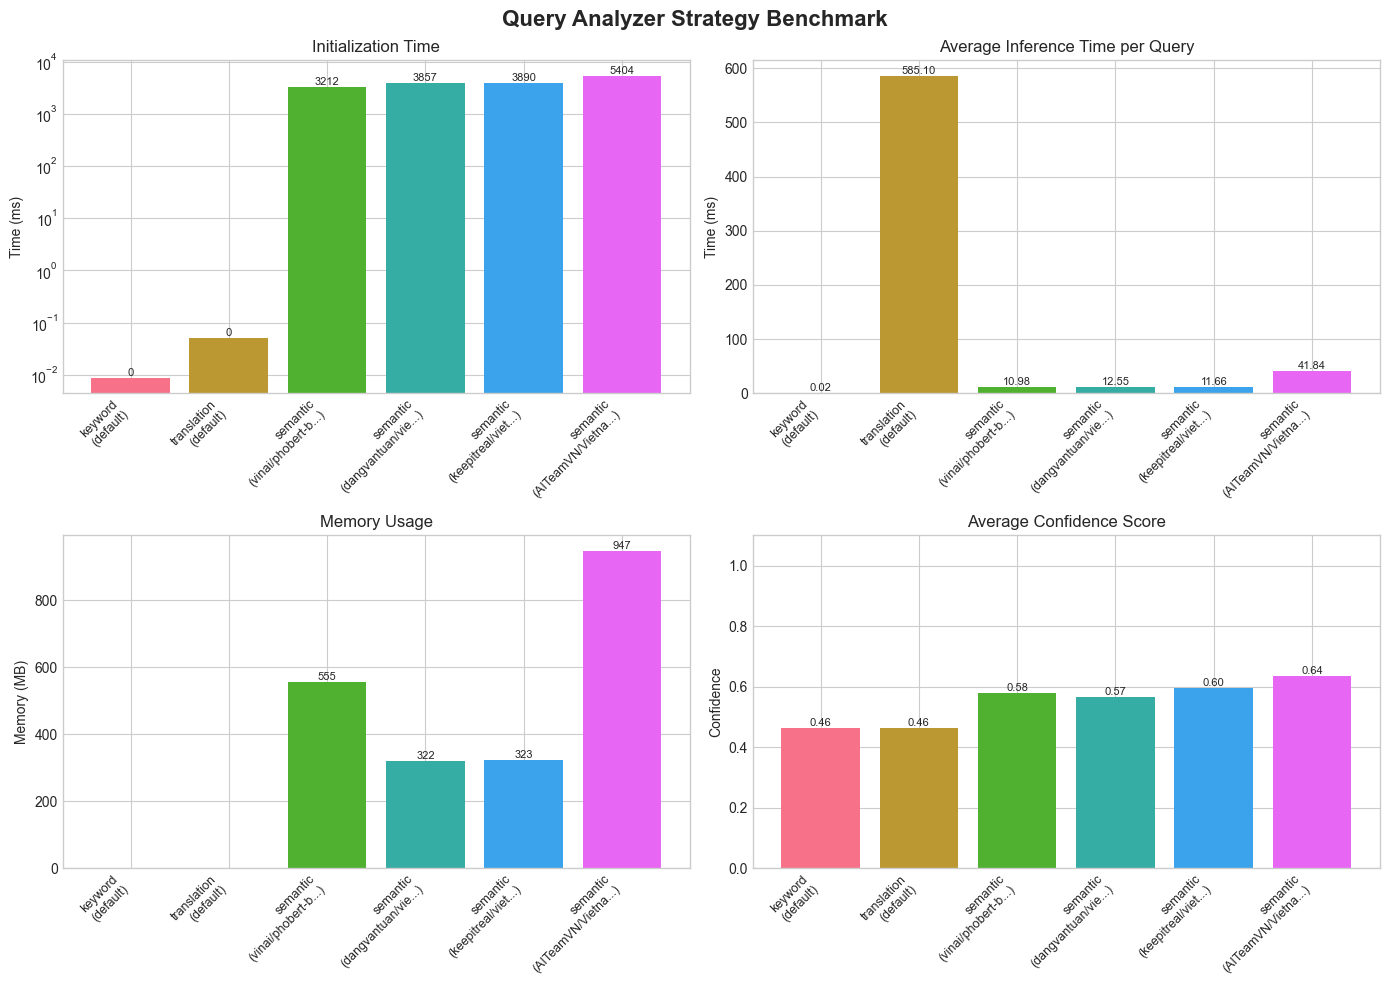

In [58]:
# Create comparison visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Query Analyzer Strategy Benchmark', fontsize=16, fontweight='bold')

labels = [f"{r.strategy_name}\n({r.model_name[:15]}...)" if len(r.model_name) > 15 
          else f"{r.strategy_name}\n({r.model_name})" for r in all_results]
colors = sns.color_palette('husl', len(all_results))

# 1. Initialization Time
ax1 = axes[0, 0]
init_times = [r.init_time_ms for r in all_results]
bars1 = ax1.bar(range(len(all_results)), init_times, color=colors)
ax1.set_xticks(range(len(all_results)))
ax1.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
ax1.set_ylabel('Time (ms)')
ax1.set_title('Initialization Time')
ax1.set_yscale('log')
for bar, val in zip(bars1, init_times):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.0f}', 
             ha='center', va='bottom', fontsize=8)

# 2. Average Inference Time
ax2 = axes[0, 1]
inf_times = [r.avg_inference_ms for r in all_results]
bars2 = ax2.bar(range(len(all_results)), inf_times, color=colors)
ax2.set_xticks(range(len(all_results)))
ax2.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
ax2.set_ylabel('Time (ms)')
ax2.set_title('Average Inference Time per Query')
for bar, val in zip(bars2, inf_times):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.2f}', 
             ha='center', va='bottom', fontsize=8)

# 3. Memory Usage
ax3 = axes[1, 0]
memory = [r.memory_mb for r in all_results]
bars3 = ax3.bar(range(len(all_results)), memory, color=colors)
ax3.set_xticks(range(len(all_results)))
ax3.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
ax3.set_ylabel('Memory (MB)')
ax3.set_title('Memory Usage')
for bar, val in zip(bars3, memory):
    if val > 0:
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.0f}', 
                 ha='center', va='bottom', fontsize=8)

# 4. Average Confidence
ax4 = axes[1, 1]
confidence = [r.avg_confidence for r in all_results]
bars4 = ax4.bar(range(len(all_results)), confidence, color=colors)
ax4.set_xticks(range(len(all_results)))
ax4.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
ax4.set_ylabel('Confidence')
ax4.set_title('Average Confidence Score')
ax4.set_ylim(0, 1.1)
for bar, val in zip(bars4, confidence):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.2f}', 
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('./outputs/query_analyzer_benchmark.png', dpi=150, bbox_inches='tight')
plt.show()

## **5. Detailed Per-Question Analysis**

In [55]:
# Compare results across strategies for each question
print("\nPer-Question Comparison")

for i, question in enumerate(TEST_QUESTIONS):
    print(f"\n{'.'*80}")
    print(f"Q{i+1}: {question}")
    print(f"{'.'*80}")
    
    for result in all_results:
        r = result.results[i]
        strategy_label = f"{result.strategy_name}" + (f"/{result.model_name.split('/')[-1]}" if result.model_name != 'default' else '')
        
        print(f"\n  [{strategy_label}]")
        print(f"    Time: {result.inference_times[i]:.3f} ms")
        print(f"    Intent: {r.question_intent.value}")
        print(f"    Objects: {r.target_objects[:4]}{'...' if len(r.target_objects) > 4 else ''}")
        print(f"    Confidence: {r.confidence:.2f}")
        if r.translated_question:
            print(f"    Translation: {r.translated_question}")


Per-Question Comparison

................................................................................
Q1: Biển báo tốc độ tối đa là bao nhiêu?
................................................................................

  [keyword]
    Time: 0.011 ms
    Intent: value
    Objects: ['max_speed_sign', 'speed_limit_sign', 'traffic_sign']
    Confidence: 0.70

  [translation]
    Time: 682.780 ms
    Intent: value
    Objects: ['max_speed_sign', 'speed_limit_sign', 'traffic_sign']
    Confidence: 0.70
    Translation: What is the maximum speed sign?

  [semantic/phobert-base]
    Time: 0.359 ms
    Intent: value
    Objects: ['highway', 'min_speed_sign', 'max_speed_sign', 'speed_limit_sign']...
    Confidence: 1.00

  [semantic/vietnamese-embedding]
    Time: 0.383 ms
    Intent: value
    Objects: ['max_speed_sign', 'speed_limit_sign', 'min_speed_sign', 'traffic_sign']
    Confidence: 1.00

  [semantic/vietnamese-sbert]
    Time: 0.221 ms
    Intent: value
    Objects: ['max_spe

In [57]:
# Export benchmark results to CSV
export_data = []
for r in all_results:
    export_data.append({
        "strategy": r.strategy_name,
        "model": r.model_name,
        "init_time_ms": r.init_time_ms,
        "avg_inference_ms": r.avg_inference_ms,
        "min_inference_ms": r.min_inference_ms,
        "max_inference_ms": r.max_inference_ms,
        "memory_mb": r.memory_mb,
        "avg_confidence": r.avg_confidence,
        "avg_objects_found": r.avg_objects_found,
    })

export_df = pd.DataFrame(export_data)
export_df.to_csv('./outputs/query_analyzer_benchmark.csv', index=False)